# Youtube scraper

#### Import libraries

In [195]:
import requests
import pandas as pd
import re, requests, csv, time
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from tqdm import tqdm
from lxml import html

# if using a Jupyter notebook, include:
%matplotlib inline

In [5]:
# Check possibility to scrap webpage - run only once
#print(requests.get('https://www.youtube.com/robots.txt').text)

#### Define functions

In [4]:
# Procedure to return HTML of the website
def getSoup(link):
    r = requests.get(link)
    r.encoding = 'UTF-8'
    if r.status_code != 200: return None
        #time.sleep(5)
    return BeautifulSoup(r.text,'lxml')

In [45]:
def infotube(link):
    '''Returns number of views, likes and dislikes of selected youtube video.'''
    page=getSoup(link)
    
    #number of views
    views=int(page.find('meta',{'itemprop' :"interactionCount"}).get("content"))
    
    #number of likes
    likes=page.find_all('span', {'class' : "yt-uix-clickcard"})[2].find_all('span', {'class' : "yt-uix-button-content"})[0].text.replace(u'\xa0', u'')
    #likes=int(likes)
    
    #number of dislikes
    dislikes=page.find_all('span', {'class' : "yt-uix-clickcard"})[4].find_all('span', {'class' : "yt-uix-button-content"})[0].text.replace(u'\xa0', u'')
    #dislikes=int(dislikes)
    
    return np.array([views,likes,dislikes])

In [6]:
def bandvid_link(band):
    '''Returns links to top-viewed videos of the band.'''
    videolist=[]
    soup=getSoup("https://www.youtube.com/results?search_query="+band.lower()+"&sp=CAM%253D")
    vids = soup.findAll('a',attrs={'class':'yt-uix-tile-link'})
    for v in vids:
        try:
            if "user" in v['href']:
                pass
            elif " - " in v.find('span').text and band.lower() in v.find('span').text.lower():
                videolist.append('https://www.youtube.com' + v['href'])
        except AttributeError:
            pass
    return videolist

In [33]:
def statisticstube(bands):
    '''returns the statistics of number of views, likes and dislikes of the most viewed youtube videos for all bands from the list'''
    bandstats=[]
    for bandname in bands:
        links=bandvid_link(bandname)
        for link in links:
            info=infotube(link)
            bandstats.append([bandname,info[0],info[1],info[2],link])
    results=pd.DataFrame(bandstats)
    results.columns=["Band","Views","Likes","Dislikes","Link"]
    return results

#### Test

In [147]:
bands=["behemoth",
       "linkin park",
       "system of a down",
       "enter shikari",
       "avantasia",
       "rammstein",
       "tool",
       "rage against the machine",
       "arch enemy"]

In [148]:
# Head of test data:
statisticstube(bands)[:10]

,Band,Views,Likes,Dislikes,Link
0,behemoth,7350832,48431,4502,https://www.youtube.com/watch?v=ji1tCcIgH5U
1,behemoth,6916380,68209,4230,https://www.youtube.com/watch?v=SnTL1L8a6YI
2,behemoth,5368454,32453,1535,https://www.youtube.com/watch?v=zzz0YVEgT5U
3,behemoth,5031879,389494,3445,https://www.youtube.com/watch?v=Sj7uLALBOEM
4,behemoth,4929085,41230,1549,https://www.youtube.com/watch?v=Cx01fOYsc6E
5,behemoth,4797336,22304,1484,https://www.youtube.com/watch?v=38j-i8jH7xk
6,behemoth,4241098,65629,3909,https://www.youtube.com/watch?v=UA_j_72psoo
7,behemoth,4054271,43230,2119,https://www.youtube.com/watch?v=Czx-OIyrQwQ
8,behemoth,3630944,56944,3207,https://www.youtube.com/watch?v=Dhfy9TPga-c
9,behemoth,3067979,32284,1425,https://www.youtube.com/watch?v=7xbZMJGpc9I


### Get the list of top 100 bands according to metal-archives.com

In [7]:
MetalArchivesLink = 'https://www.metal-archives.com/stats'
TopList = getSoup(MetalArchivesLink)

#RankedList = []

#TableTop = TopList.find('div',{'class' : 'ui-tabs-panel-content'})
# After the request server went down... :D
# ... so we downloaded similar data as a csv file instead.

ConnectionError: HTTPSConnectionPool(host='www.metal-archives.com', port=443): Max retries exceeded with url: /stats (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x1129582e8>: Failed to establish a new connection: [Errno 60] Operation timed out',))

In [49]:
# If the csv is not loaded yet, load it.
if not TOP100:
    TOP100 = pd.read_csv("metal_bands_2017.csv")

# Show the head of data
print(TOP100[:5])

band_name_list = TOP100['band_name']

# Run only once! 
statisticstube(band_name_list)

StatTube = statisticstube(band_name_list)

   Rank    band_name  fans  formed          origin split  \
0     0  Iron Maiden  4195    1975  United Kingdom     -   
1     1        Opeth  4147    1990          Sweden  1990   
2     2    Metallica  3712    1981             USA     -   
3     3     Megadeth  3105    1983             USA  1983   
4     4  Amon Amarth  3054    1988          Sweden     -   

                                              style  
0                   New wave of british heavy,Heavy  
1  Extreme progressive,Progressive rock,Progressive  
2                             Heavy,Bay area thrash  
3                            Thrash,Heavy,Hard rock  
4                                     Melodic death  


## Rank comparison: Music database vs. Youtube 'Likes'

In [144]:
#Merge previous tables: if not TOP100: TOP100 = pd.read_csv("metal_bands_2017.csv")
#print(StatTube[:10])

# Run just once to get rid of links with necessity to login
#StatTube = StatTube. drop([213, 283, 993, 923], axis=0)

# Create variable  Share Like to see the popularity of each video to subsequent rank of band
# Convert strings to numbers

StatTube[['Likes', 'Dislikes', 'Views']] = StatTube[['Likes', 'Dislikes', 'Views']].apply(pd.to_numeric)
StatTube['Share Likes'] = StatTube['Likes'] / (StatTube['Likes'] + StatTube['Dislikes'])
StatTube['Views w. w. Share Likes'] = StatTube['Share Likes'] * StatTube['Views']


StatTube['Rank Views'] = StatTube.groupby('Band')['Views'].rank(ascending=False)


# Show head of StatTube
print(StatTube[:10])

# We obtained list of 100 bands concerned as TOP 100 in a subset and we resorted them with respect to average youtube ranking
Grouped = StatTube.groupby('Band').mean() #.sort_values('Total Rank', axis=0, ascending=False)
Grouped['Rank Views'] = Grouped['Views'].rank(ascending=False)
Grouped['VWWS Like'] = Grouped['Share Likes'].rank(ascending=False)
Grouped['Total Rank'] = Grouped['Rank Views'] + Grouped['VWWS Like']

print (Grouped.sort_values('Total Rank', axis=0, ascending=True))


          Band     Views   Likes  Dislikes  \
0  Iron Maiden  82517925  399865     14417   
1  Iron Maiden  61541666  226295     10637   
2  Iron Maiden  52386275  193892     11965   
3  Iron Maiden  48609015  172927      4850   
4  Iron Maiden  32089284  155794      6312   
5  Iron Maiden  27114654  148178      4690   
6  Iron Maiden  26327653  162723      4534   
7  Iron Maiden  26321947  107043      3999   
8  Iron Maiden  25789191  138013      4361   
9  Iron Maiden  22053858  215572      6630   

                                          Link  Share Likes  \
0  https://www.youtube.com/watch?v=2G5rfPISIwo     0.965200   
1  https://www.youtube.com/watch?v=J51LPlP-s9o     0.955105   
2  https://www.youtube.com/watch?v=p32b5nNq1zw     0.941877   
3  https://www.youtube.com/watch?v=dTaD9cd8hvw     0.972719   
4  https://www.youtube.com/watch?v=WxnN05vOuSM     0.961063   
5  https://www.youtube.com/watch?v=Ij99dud8-0A     0.969320   
6  https://www.youtube.com/watch?v=X4bgXH3sJ2Q     0

From table it is obvious, that top ranked band do not have the highest average share of likes on total number of vvaluations and its popularity come from number of views. If we merge two approaches of ranking, we obtain Nile as the top metal band.

## Result
Youtube.com page, which contains search results, is programmed as a Javascript-heavy website, with quite a lot of side libraries, that we were not able to scrap with respect to our knowledge of Python and HTML. We were not even able to find any existing code covering the topic. The structure is so problematic to allow functionalities like infinite scrolling, loading bars etc. In case of displayed views, we were not even able to find every view count within a BS file - views for different results are placed in different blocks with respect to the type of the video. 

For example, we were not able to navigate to class: 'style-scope ytd-video-meta-block'

In case of a single video, the problem is much easier and we were able to obtain data and re-rank TOP 100 bands according to their views weighted with average share of likes on total number of comments.

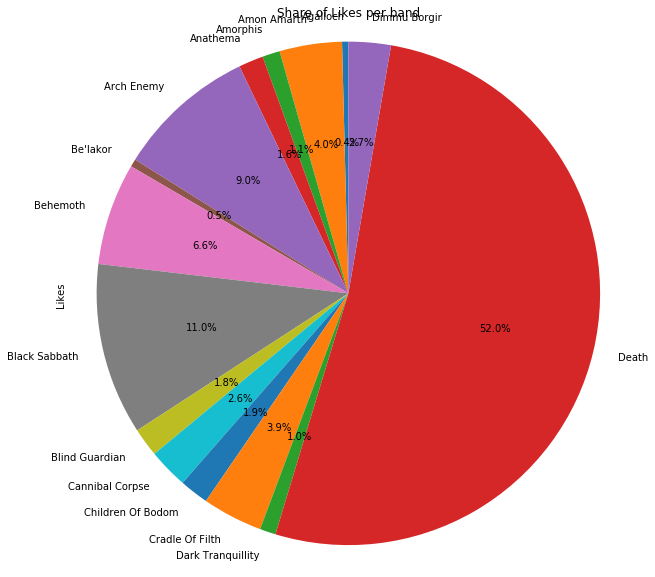

In [207]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
#labels = Grouped['Band']
#sizes  = Grouped['Views']

# autopct create %, start angle represent starting point
Grouped['Likes'][:15].plot(kind='pie',
                            figsize=(10, 10),
                            autopct='%2.1f%%', # add in percentages
                            startangle=90,     # start angle 90° (Africa)
                            shadow=False,       # add shadow      
                            )
 
plt.title('Share of Likes per band')
plt.axis('equal') # Sets the pie chart to look like a circle.
 
plt.show()